In [33]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt


# 1. Defining the structure

We want to model a photonic crystal with lattice constant *a* = 0.420 microns. 
- radius = 0.3a
- wavelength range from 1.50 to 1.56 microns
- (x, y, z) dimensions = (15, 10, 0.26)
- refractive index = 3.23

For now, we ignore thickness and treat the crystal as a 2-dimensional structure. 

In [147]:
resolution = 20
a = 0.420
w = 15
h = 10
d = 0.26
r = 0.3 * a
default_material = mp.Medium(epsilon=10.4329)

def get_hole_centers(w, h, a, line_defect=False):
    horizontal_spacing = a * np.sqrt(3) / 2
    padding = 0.0

    h = h - padding
    w = w - padding

    num_rows = int(h // a)
    halfway_point = num_rows // 2

    start_x = -w / 2
    end_x = w / 2

    hole_centers = []

    for row in range(0, num_rows):
        if line_defect and row == halfway_point:
            continue

        y = (row - halfway_point) * a
        x = start_x
        if row % 2 == 1:
            x += horizontal_spacing / 2
        
        while x <= end_x:
            hole_centers.append((x, y))
            x += horizontal_spacing

    return hole_centers

sx = w
sy = h
cell = mp.Vector3(sx,sy,0)

dpml = 1.0
pml_layers = [mp.PML(dpml)]

hole_centers = get_hole_centers(w, h, a, line_defect=True)
holes = [mp.Cylinder(r, center=mp.Vector3(x, y), material=mp.air) 
         for x, y in hole_centers]
geometry = [mp.Block(size=mp.Vector3(w, h, mp.inf),
                     center=mp.Vector3(),
                     material=default_material),
                     *holes,
                     ]

for hole in holes[0:10]:
    print(hole.center)

Vector3<-7.5, -4.62, 0.0>
Vector3<-7.136269330410536, -4.62, 0.0>
Vector3<-6.772538660821072, -4.62, 0.0>
Vector3<-6.408807991231607, -4.62, 0.0>
Vector3<-6.045077321642143, -4.62, 0.0>
Vector3<-5.681346652052679, -4.62, 0.0>
Vector3<-5.317615982463215, -4.62, 0.0>
Vector3<-4.953885312873751, -4.62, 0.0>
Vector3<-4.590154643284286, -4.62, 0.0>
Vector3<-4.226423973694822, -4.62, 0.0>


Now we define a light source. This is a Gaussian source near the left side of the device, in the center of a group of holes. What we really want here is a quantum dot source.  

In [148]:
# fcen = 0.6666  # pulse center frequency
fcen = 0.65
df = 0.1     # pulse width (in frequency)

source_x_center = (holes[4].center.x + holes[5].center.x) / 2

sources = [mp.Source(mp.GaussianSource(fcen,fwidth=df),
                     component=mp.Ez,
                     center=mp.Vector3(source_x_center),
                     size=mp.Vector3(0,a/2,0))]

     block, center = (0,0,0)
          size (15,10,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (10.4329,10.4329,10.4329)
     cylinder, center = (-7.5,-4.62,0)
          radius 0.126, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-7.13627,-4.62,0)
          radius 0.126, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-6.77254,-4.62,0)
          radius 0.126, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-6.40881,-4.62,0)
          radius 0.126, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-6.04508,-4.62,0)
          radius 0.126, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder

, center = (-5.68135,-4.62,0)
          radius 0.126, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-5.31762,-4.62,0)
          radius 0.126, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-4.95389,-4.62,0)
          radius 0.126, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-4.59015,-4.62,0)
          radius 0.126, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     ...(+ 905 objects not shown)...


<Axes: xlabel='X', ylabel='Y'>

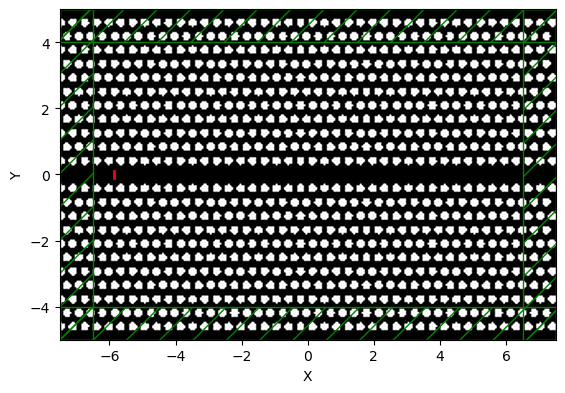

In [149]:
sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    resolution=resolution)
sim.plot2D()

### 1b. Visualize the field

In [150]:
sim.run(until=200)

-----------
Initializing structure...
time for choose_chunkdivision = 0.00773478 s
Working in 2D dimensions.
Computational cell is 15 x 10 x 0 with resolution 20
     block, center = (0,0,0)
          size (15,10,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (10.4329,10.4329,10.4329)
     cylinder, center = (-7.5,-4.62,0)
          radius 0.126, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-7.13627,-4.62,0)
          radius 0.126, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-6.77254,-4.62,0)
          radius 0.126, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-6.40881,-4.62,0)
          radius 0.126, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-6.04508,-4.62,0)
          rad

FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)


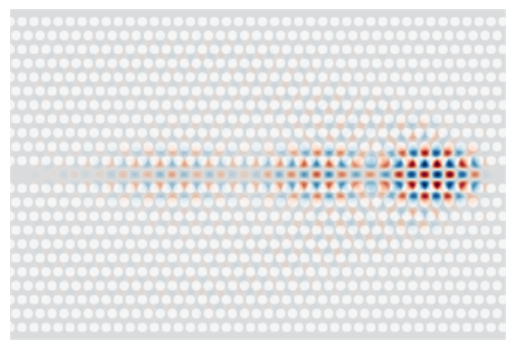

In [151]:
eps_data = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Dielectric)
ez_data = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Ez)
plt.figure()
plt.imshow(eps_data.transpose(), interpolation='spline36', cmap='binary')
plt.imshow(ez_data.transpose(), interpolation='spline36', cmap='RdBu', alpha=0.9)
plt.axis('off')
plt.show()

# 2. Get the Flux

Let's get the transmission spectrum at the right end of the waveguide, right before the edge of the cell. 

To do this, we need to determine the transmittance in the waveguide structure and normalize it by the incident power (computed by using the same point in a structure that only contains air).

First, we compute the transmittance from the structure itself. 

     block, center = (0,0,0)
          size (15,10,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (10.4329,10.4329,10.4329)
     cylinder, center = (-7.5,-4.62,0)
          radius 0.126, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-7.13627,-4.62,0)
          radius 0.126, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-6.77254,-4.62,0)
          radius 0.126, height 1e+20, axis (0, 0, 1)


          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-6.40881,-4.62,0)
          radius 0.126, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-6.04508,-4.62,0)
          radius 0.126, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-5.68135,-4.62,0)
          radius 0.126, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-5.31762,-4.62,0)
          radius 0.126, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-4.95389,-4.62,0)
          radius 0.126, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (-4.59015,-4.62,0)
          radius 0.126, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     ...(+ 905 objects no

<Axes: xlabel='X', ylabel='Y'>

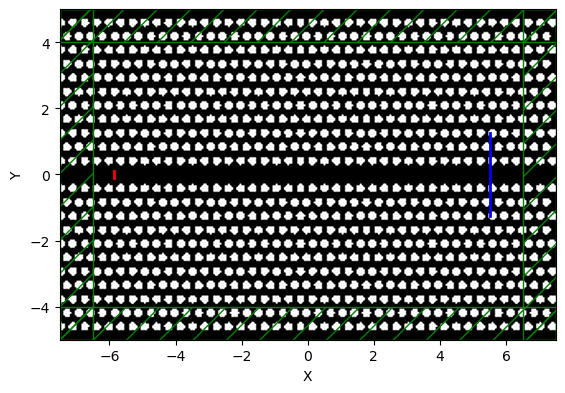

In [152]:
nfreq = 500  # number of frequencies at which to compute flux

# transmitted flux (across a 3a tall line, 0.1 micron from the right edge of the waveguide)

flux_x = w / 2 - dpml - 1

tran_fr = mp.FluxRegion(center=mp.Vector3(flux_x, 0, 0), size=mp.Vector3(0, h/4,0))
tran = sim.add_flux(fcen, df, nfreq, tran_fr)

sim.plot2D()

In [153]:
pt = mp.Vector3(flux_x, h/4)

sim.run(until_after_sources=mp.stop_when_fields_decayed(50,mp.Ez,pt,1e-3))

field decay(t = 200.0): 3.8852580919811126e-08 / 3.8852580919811126e-08 = 1.0
on time step 8000 (time=200), 0.000568088 s/step


field decay(t = 250.025): 9.113639013415428e-08 / 9.113639013415428e-08 = 1.0
field decay(t = 300.05): 8.006004958833819e-08 / 9.113639013415428e-08 = 0.8784641290980306
field decay(t = 350.07500000000005): 1.7759728933866048e-08 / 9.113639013415428e-08 = 0.1948697870052065
field decay(t = 400.1): 1.7323661690809725e-08 / 9.113639013415428e-08 = 0.19008501066707828
field decay(t = 450.125): 5.0874941139978383e-08 / 9.113639013415428e-08 = 0.5582286182839766
on time step 18191 (time=454.775), 0.000392504 s/step
field decay(t = 500.15000000000003): 5.105908864888919e-08 / 9.113639013415428e-08 = 0.5602491888665917
field decay(t = 550.15): 1.688119053325474e-08 / 9.113639013415428e-08 = 0.18522996695837246
field decay(t = 600.1750000000001): 2.5772734971548974e-09 / 9.113639013415428e-08 = 0.028279301971047
field decay(t = 650.2): 2.1095477096268174e-09 / 9.113639013415428e-08 = 0.023147150183604245
on time step 27641 (time=691.025), 0.000423303 s/step
field decay(t = 700.225): 1.18578134

In [154]:
waveguide_tran_flux = mp.get_fluxes(tran)

# 3. Get flux for a reference structure (all air)

For our reference transmittance, we define a cell with the same dimensions that only contains air. 

     block, center = (0,0,0)
          size (15,10,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (10.4329,10.4329,10.4329)


<Axes: xlabel='X', ylabel='Y'>

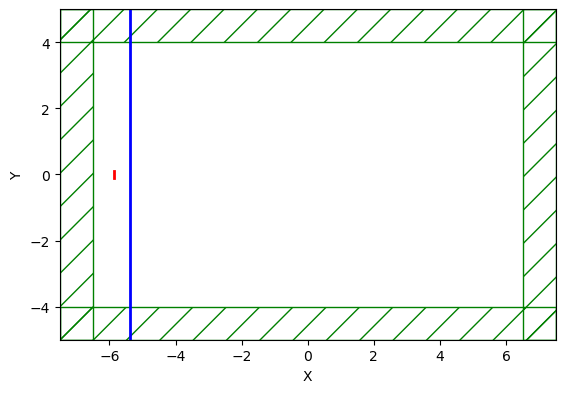

In [155]:
sim.reset_meep()
geometry = []
geometry = [mp.Block(size=mp.Vector3(w, h, mp.inf),
                     center=mp.Vector3(),
                     material=default_material),
                     ]
sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    resolution=resolution)


tran_fr = mp.FluxRegion(center=mp.Vector3(source_x_center + 0.5, 0, 0), size=mp.Vector3(0,h,0))
tran = sim.add_flux(fcen, df, nfreq, tran_fr)
sim.plot2D()

In [156]:
pt = mp.Vector3(flux_x, h/4)

sim.run(until_after_sources=mp.stop_when_fields_decayed(50,mp.Ez,pt,5e-3))

air_tran_flux = mp.get_fluxes(tran)

flux_freqs = mp.get_flux_freqs(tran)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000217915 s
Working in 2D dimensions.
Computational cell is 15 x 10 x 0 with resolution 20
     block, center = (0,0,0)
          size (15,10,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (10.4329,10.4329,10.4329)
time for set_epsilon = 0.17263 s
-----------
field decay(t = 50.025000000000006): 2.1474590323852523e-11 / 2.1474590323852523e-11 = 1.0
field decay(t = 100.05000000000001): 0.00018245930184789308 / 0.00018245930184789308 = 1.0
field decay(t = 150.07500000000002): 5.743152396763454e-05 / 0.00018245930184789308 = 0.314763475394158
field decay(t = 200.10000000000002): 1.4934158907406587e-17 / 0.00018245930184789308 = 8.184926038934659e-14
run 0 finished at t = 200.10000000000002 (8004 timesteps)


### 3b. Plotting the field for the reference structure

In [157]:
sim.run(until=200)

FloatProgress(value=200.10000610351562, description='0% done ', max=400.1000061035156, min=200.10000610351562)

on time step 8617 (time=215.425), 0.000464201 s/step
run 1 finished at t = 400.1 (16004 timesteps)


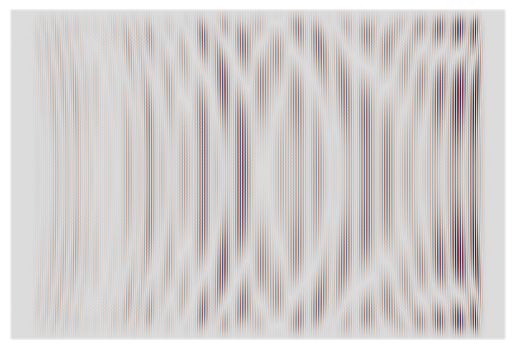

In [158]:
eps_data = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Dielectric)
ez_data = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Ez)
plt.figure()
plt.imshow(eps_data.transpose(), interpolation='spline36', cmap='binary')
plt.imshow(ez_data.transpose(), interpolation='spline36', cmap='RdBu', alpha=0.9)
plt.axis('off')
plt.show()

# Plot the transmittance spectrum

In the following plot, transmittance is calculated by normalizing the waveguide transmittance flux by the air transmittance flux. Note that the transmittance sometimes goes above 1 because we are normalizing it by the flux in a region that likely gets less of that wavelength when there is no waveguide present. 

Is there a better reference to compare this against?

In [159]:
print(waveguide_tran_flux)

[0.0005795915476657021, 0.0005155771698562946, 0.000572861752704862, 0.0005732429106920002, 0.000529979220944295, 0.000605111532682543, 0.0005603132025178508, 0.0005622917240150943, 0.0006210134385459903, 0.0005538066659499777, 0.0006041598705082704, 0.0006190940709766328, 0.0005643390013942329, 0.0006424545992806683, 0.0006069322561282782, 0.0005948097740842279, 0.0006655910315683879, 0.0005977908477148207, 0.0006386743026535115, 0.0006693400171965942, 0.0006043043557649798, 0.0006828138191367604, 0.0006592430280531425, 0.0006322184428691898, 0.0007137765615594249, 0.0006482981229015085, 0.0006772758476607711, 0.0007244474802221563, 0.0006508604537304505, 0.0007269200436478256, 0.0007178694864391841, 0.0006756106230164045, 0.000766182240698659, 0.0007062044123652058, 0.0007210266614874086, 0.0007850237154066838, 0.000705133873900516, 0.000775709824357178, 0.0007835666654111102, 0.0007262664130288689, 0.0008236215863697848, 0.0007725298670611867, 0.000771217957685988, 0.000851864676263

In [163]:
print(air_tran_flux)

[1.561724782309394e-05, 1.6913879797018552e-05, 1.831234001328899e-05, 1.9820122534752368e-05, 2.1445231382463762e-05, 2.3196211951504534e-05, 2.5082184114206257e-05, 2.7112877083593766e-05, 2.929866611144055e-05, 3.165061109770145e-05, 3.418049718929183e-05, 3.6900877448326057e-05, 3.982511767143537e-05, 4.296744344317984e-05, 4.634298950844757e-05, 4.996785154966128e-05, 5.3859140456062004e-05, 5.803503917359417e-05, 6.25148622245189e-05, 6.731911798706623e-05, 7.246957382580892e-05, 7.798932416397057e-05, 8.390286158930436e-05, 9.02361510846642e-05, 9.701670747490221e-05, 0.00010427367618062048, 0.00011203791736882169, 0.00012034209358953321, 0.0001292207609859125, 0.00013871046416370105, 0.00014884983480406642, 0.00015967969410110846, 0.00017124315910281267, 0.00018358575303077266, 0.00019675551965061958, 0.00021080314176058482, 0.00022578206386150067, 0.00024174861906648814, 0.00025876216030199916, 0.000276885195847377, 0.0002961835292521462, 0.00031672640366344173, 0.000338586650

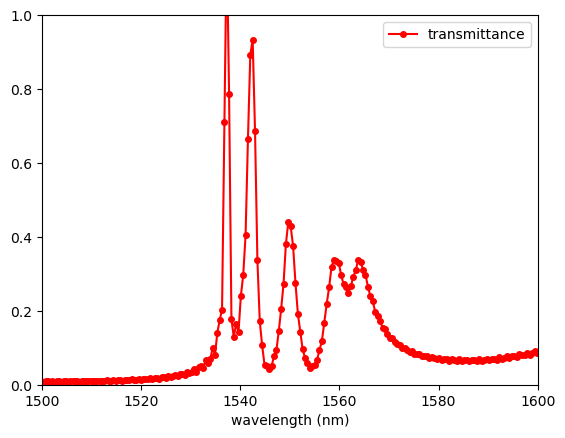

In [165]:
wl = []
Rs = []
Ts = []
for i in range(nfreq):
    wl = np.append(wl, 1000 * 1/flux_freqs[i])
    Ts = np.append(Ts,waveguide_tran_flux[i]/air_tran_flux[i])

if mp.am_master():
    plt.figure()
    plt.plot(wl,Ts,'ro-',label='transmittance', markersize=4)
    plt.axis([1500, 1600, 0, 1])
    plt.xlabel("wavelength (nm)")
    plt.legend(loc="upper right")
    plt.show()